In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import os
import sys
import matplotlib.pyplot as plt
import json
import copy
import seaborn as sns

# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
EXTERNAL_LIBS_PATH = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
sys.path.insert(1, EXTERNAL_LIBS_PATH)

# Load cortum libs
import NN_interpretability as nn_inter
import Data_augmentation as data_aug

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Set parameters
params = {}
params['base_path'] = '/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability'
# XC_t5 omitida por R2 bajo
#params['models_list'] = ['BL_t1', 'BL_t4', 'BL_t8', 'XC', 'XC_t3', 'XC_t9', 'RN', 'RN_t2', 'RN_t3', 'RN_t4', 'RN_t6']
params['models_list'] = ['BL']
params['CMA'] = 'CMA_0'
params['cells'] = ['340547', '307720', '321021', '232615', '205760', '379184']

plot_dir = os.path.join(params['base_path'], 'Plots')
os.makedirs(plot_dir, exist_ok=True)

# Notas
- BL_t8 mide 08_H3K4ME3 usando 09_SRRM2

# 1.- Load Data

## 1.1.- Load general data (independent to the model)

In [4]:
# Load metadata
with open(os.path.join(params['base_path'], 'Metadata', 'filtered_metadata.csv'), 'r') as file:
    metadata_df = pd.read_csv(file)
metadata_df.head()

mapobject_id_cell  mapobject_id plate_name well_name  well_pos_y  \
0             263042        263055    plate01       J16           0   
1             263043        263056    plate01       J16           0   
2             263044        263057    plate01       J16           0   
3             263045        263058    plate01       J16           0   
4             263047        263060    plate01       J16           0   

   well_pos_x  tpoint  zplane  label  is_border plate_name_cell  \
0           0       0       0      4          0         plate01   
1           0       0       0      5          0         plate01   
2           0       0       0      6          0         plate01   
3           0       0       0      7          0         plate01   
4           0       0       0      9          0         plate01   

  well_name_cell  well_pos_y_cell  well_pos_x_cell  tpoint_cell  zplane_cell  \
0            J16                0                0            0            0   
1            J16                0                0            0            0   
2            J16                0                0            0            0   
3            J16                0                0            0            0   
4            J16                0                0            0            0   

   label_cell  is_border_cell  is_mitotic  is_mitotic_labels  \
0           4               0         0.0                NaN   
1           5               0         0.0                NaN   
2           6               0         0.0                NaN   
3           7               0         0.0                NaN   
4           9               0         0.0                NaN   

   is_polynuclei_HeLa  is_polynuclei_HeLa_labels  is_polynuclei_184A1  \
0                 0.0                        NaN                  0.0   
1                 0.0                        NaN                  0.0   
2                 0.0                        NaN                  0.0   
3                 0.0                        NaN                  0.0   
4                 0.0                        NaN                  0.0   

   is_polynuclei_184A1_labels cell_cycle cell_type perturbation  duration  \
0                         NaN          S     184A1         DMSO     720.0   
1                         NaN          S     184A1         DMSO     720.0   
2                         NaN         G1     184A1         DMSO     720.0   
3                         NaN          S     184A1         DMSO     720.0   
4                         NaN         G1     184A1         DMSO     720.0   

   cell_size  00_DAPI_avg  07_H2B_avg  01_CDK9_pT186_avg  03_CDK9_avg  \
0     8401.0    39.610201  282.212391          14.709787    34.481345   
1    12207.0    34.884746  249.743762          14.587963    33.729957   
2    15734.0    31.429217  184.722779           7.892179    19.263491   
3    15767.0    43.349090  241.460906          18.110119    44.601291   
4    11930.0    28.164459  149.241408          27.710272    72.874109   

   05_GTF2B_avg  07_SETD1A_avg  08_H3K4me3_avg  09_SRRM2_avg  10_H3K27ac_avg  \
0    122.127518      29.408288       48.079878     56.508154       71.844750   
1    104.787060      25.446742       35.599046     54.977671       48.061287   
2     81.864454      23.929299       29.536900     39.606383       39.047856   
3    122.976267      40.604674       48.760110     58.076779       77.012867   
4    148.002903      51.391368       56.976488    116.255474       56.907744   

   11_KPNA2_MAX_avg  12_RB1_pS807_S811_avg  13_PABPN1_avg  14_PCNA_avg  \
0         93.999276             108.771761     157.808500    85.331438   
1         90.354757              97.722536     145.751775    95.141995   
2         77.348039              12.910413     149.859577    42.855445   
3        121.283321             104.755645     159.792550    84.807594   
4         66.943473              97.452245     187.995952    53.530015   

   15_SON_avg   16_H3_avg  17_HDAC3_avg 

In [5]:
# Load parameters
with open(os.path.join(params['base_path'], 'Metadata', 'parameters.json'), 'r') as file:
    model_params = json.load(file)
#model_params.keys()

In [6]:
# Load Channels
with open(os.path.join(params['base_path'], 'Metadata', 'channels.csv'), 'r') as file:
    channels_df = pd.read_csv(file)
# Get input channel ids
mask = channels_df.name.isin(model_params['input_channels'])
input_ids = channels_df[mask].channel_id.values
# Get output channel id
mask = channels_df.name == '00_EU'
output_id = channels_df[mask].channel_id.values[0]
# Get normalization values
norm_vals = channels_df.sort_values(by=['channel_id']).normalization_vals.values
channels_df

channel_id               name  normalization_vals    type
0            0            00_DAPI                74.0   input
1            1             07_H2B               333.0   input
2            2      01_CDK9_pT186                53.0   input
3            3            03_CDK9               104.0   input
4            4           05_GTF2B               203.0   input
5            5          07_SETD1A               108.0   input
6            6         08_H3K4me3               118.0   input
7            7           09_SRRM2               323.0   input
8            8         10_H3K27ac               193.0   input
9            9       11_KPNA2_MAX               130.0   input
10          10  12_RB1_pS807_S811               198.0   input
11          11          13_PABPN1               434.0   input
12          12            14_PCNA               166.0   input
13          13             15_SON               287.0   input
14          14              16_H3               480.0   input
15          15           17_HDAC3               169.0   input
16          16       19_KPNA1_MAX               158.0   input
17          17           20_SP100               397.0   input
18          18             21_NCL               223.0   input
19          19          01_PABPC1                58.0   input
20          20            02_CDK7               309.0   input
21          21            03_RPS6                49.0   input
22          22              05_Sm               117.0   input
23          23          07_POLR2A               364.0   input
24          24           09_CCNT1               225.0   input
25          25      10_POL2RA_pS2               581.0   input
26          26             11_PML               149.0   input
27          27            12_YAP1               213.0   input
28          28      13_POL2RA_pS5               481.0   input
29          29        15_U2SNRNPB                97.0   input
30          30            18_NONO               637.0   input
31          31          20_ALYREF               721.0   input
32          32            21_COIL                28.0   input
33          33           00_BG488                19.0   input
34          34           00_BG568                 9.0   input
35          36   09_SRRM2_ILASTIK             60065.0   input
36          37     15_SON_ILASTIK             60926.0   input
37          35              00_EU                 1.0  output

## 1.2.- Load Model Data

In [7]:
#models_path = os.path.join(params['base_path'], 'Models', params['model_dir'])
targets_df = pd.DataFrame()
for i, model in enumerate(params['models_list']):
    print('Reading predicted values for model: ', model)
    model_path = os.path.join(os.path.join(params['base_path'], 'Models', model))
    temp_path = os.path.join(model_path, 'targets_'+params['CMA']+'.csv')
    with open(temp_path, 'r') as file:
        temp_df = pd.read_csv(file)
    temp_df = temp_df.drop(['y - y_hat'], axis=1)
    prediction_name = 'y_hat'+'_'+model
    temp_df[prediction_name] = temp_df.y_hat
    temp_df = temp_df.drop(['y_hat'], axis=1)
    if i == 0:
        targets_df = temp_df.copy()
    else:
        temp_df = temp_df[['mapobject_id_cell', prediction_name]]
        targets_df = targets_df.merge(temp_df, 
                                      left_on='mapobject_id_cell',
                                      right_on='mapobject_id_cell',
                                      how='left')
mask = targets_df.mapobject_id_cell.isin(np.array(params['cells'], dtype=np.int64))
round(targets_df[mask], 2)

Reading predicted values for model:  BL


y  mapobject_id_cell    set perturbation cell_cycle  y_hat_BL
56    332.62             321021  train       normal         G1    343.85
2376  440.33             340547  train         DMSO         G1    440.33
2817  361.85             205760  train       normal         G1    400.99
3006  319.87             232615    val       normal         G1    356.08
3036  432.03             379184    val         DMSO          S    386.70
3133  366.16             307720    val         DMSO         G1    324.76

## 1.3.- Load cells

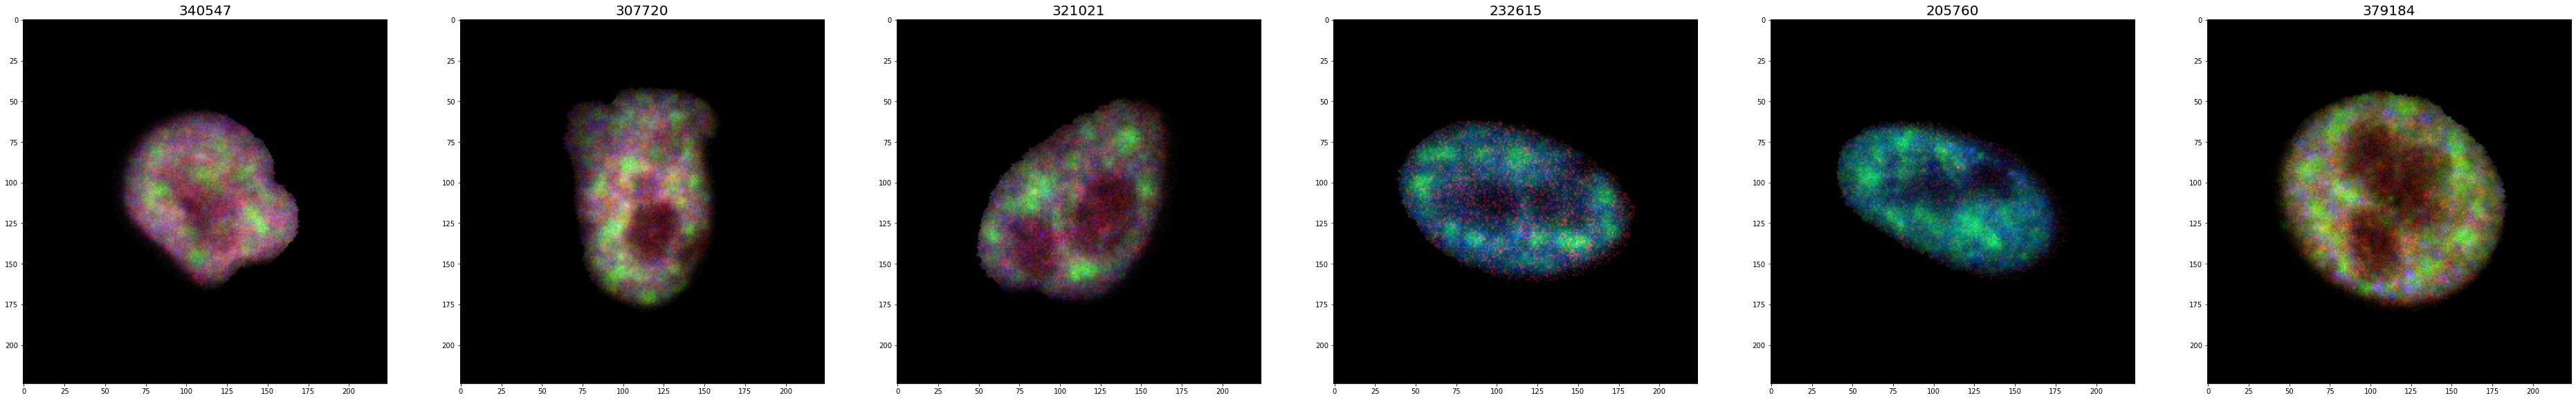

In [8]:
cells = {}
n_cells = len(params['cells'])
plt.figure(figsize=(n_cells*11,10))

for i, cell in enumerate(params['cells'], 1):
    temp_path = os.path.join(params['base_path'], 'Cells', cell+'.npz')
    temp_cell = np.load(temp_path)
    # Normalize cell
    cells[cell+'_img'] = copy.deepcopy(temp_cell['img'] / norm_vals)
    # filter accordingly to the input channels
    cells[cell+'_img'] = cells[cell+'_img'][:,:,input_ids].astype(np.float32)
    cells[cell+'_mask'] = copy.deepcopy(temp_cell['mask'])
    
    # Plot cells
    temp_img = (cells[cell+'_img'] / np.max(cells[cell+'_img'], axis=(0,1)))[:,:,10:13]
    plt.subplot(1, n_cells, i)
    nn_inter.plot_cell(img=temp_img, title=cell)

# 2.- Get Score Matrix for each cell (VarGrad IG)

# 2.2.- Load VarGrad IG

### Load Score Maps

In [9]:
VarGrad_IG = {}
for model in params['models_list']:
    print('Loading score maps from model ', model)
    temp_path_1 = os.path.join(params['base_path'], 'Score_maps', model, 'data')
    files = os.listdir(temp_path_1)
    # only load cells that match the selected ids
    files = [f for f in files if f[0:-4] in params['cells']]
    for f in files:
        print('\tLoading cell map ', f)
        temp_path_2 = os.path.join(temp_path_1, f)
        key = model+'_'+f[0:-4]
        VarGrad_IG[key] = np.load(temp_path_2)
    print("")

Loading score maps from model  BL
	Loading cell map  340547.npy
	Loading cell map  307720.npy
	Loading cell map  205760.npy
	Loading cell map  232615.npy
	Loading cell map  379184.npy
	Loading cell map  321021.npy



### Plote Score maps for both models and compare

In [10]:
VarGrad_IG.keys()

dict_keys(['BL_340547', 'BL_307720', 'BL_205760', 'BL_232615', 'BL_379184', 'BL_321021'])

Plotting cell: 205760


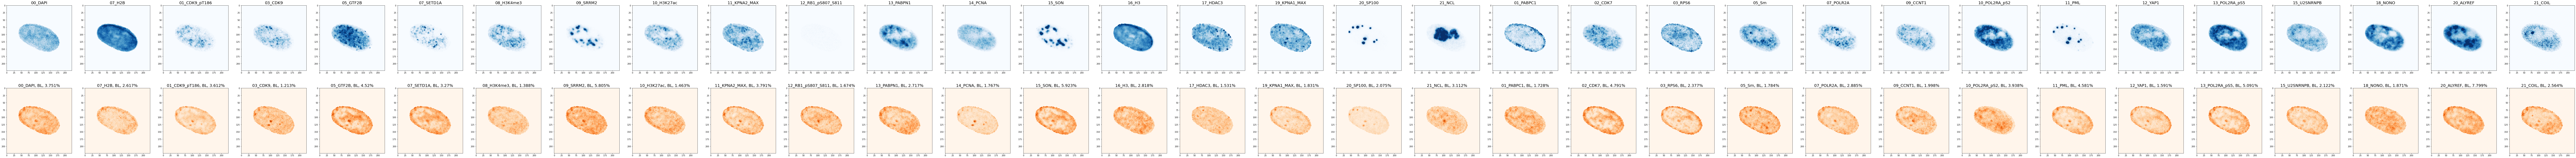

In [11]:
mod2plot = ['RN_t6', 'XC_t3', 'XC_t5', 'BL_t4', 'BL_t8']
mod2plot = params['models_list']

#for cell in params['cells']:
for cell in ['205760']:
    top_percent = 1
    plot_name = os.path.join(plot_dir, cell+'_'+str(top_percent)+'.jpg')
    print('Plotting cell: '+cell)
    temp_Score_maps = {key[:-7]: VarGrad_IG[key] for key in VarGrad_IG.keys() if ((cell in key) and (key[0:-7] in mod2plot))} #or ('RN_t6' in key))}
    nn_inter.plot_VarGrad_IG_2(img=cells[cell+'_img'],
                               img_mask=cells[cell+'_mask'],
                               score_maps=temp_Score_maps,
                               top_percent=top_percent,
                               channels_df=channels_df,
                               img_size=(7,7),
                               score_map_same_sacale=False,
                               channels_2_plot=None,
                               plot_overlap=False,
                               plot_colorbar=False,
                               #plot_name=plot_name
                              )

# 3.- Comulative variance plot

In [12]:
score_map_stddev = pd.DataFrame()
for model in params['models_list']:
    temp_path = os.path.join(params['base_path'], 'Score_maps', model)    
    temp_df = pd.read_csv(os.path.join(temp_path, 'score_map_stddev.csv'))
    score_map_stddev = pd.concat((score_map_stddev, temp_df), ignore_index=True)
score_map_stddev

00_DAPI    07_H2B  01_CDK9_pT186   03_CDK9  05_GTF2B  07_SETD1A  \
0  0.037305  0.025830       0.034667  0.011955  0.041498   0.033321   
1  0.039135  0.026890       0.034647  0.011387  0.043452   0.032552   
2  0.038065  0.024262       0.038581  0.012234  0.044911   0.033864   
3  0.039034  0.025008       0.035713  0.011478  0.051990   0.029143   
4  0.037510  0.026174       0.036121  0.012132  0.045200   0.032700   
5  0.036265  0.023447       0.039859  0.013306  0.044152   0.035672   

   08_H3K4me3  09_SRRM2  10_H3K27ac  11_KPNA2_MAX  12_RB1_pS807_S811  \
0    0.016085  0.060464    0.015914      0.037554           0.014677   
1    0.013645  0.056981    0.015467      0.039972           0.014753   
2    0.013410  0.060591    0.012609      0.041306           0.015608   
3    0.012283  0.050531    0.015801      0.040167           0.013744   
4    0.013880  0.058054    0.014633      0.037907           0.016742   
5    0.013067  0.061635    0.011915      0.041735           0.015461   

   13_PABPN1   14_PCNA    15_SON     16_H3  17_HDAC3  19_KPNA1_MAX  20_SP100  \
0   0.028545  0.017941  0.059111  0.025727  0.014439      0.017625  0.022080   
1   0.024698  0.017469  0.059855  0.029334  0.012123      0.018446  0.021618   
2   0.025590  0.018214  0.057455  0.027545  0.011842      0.018869  0.022824   
3   0.022223  0.019912  0.066344  0.024330  0.013863      0.019759  0.017312   
4   0.027171  0.017675  0.059233  0.028180  0.015315      0.018307  0.020745   
5   0.027225  0.019185  0.055686  0.025523  0.011661      0.018678  0.024333   

     21_NCL  01_PABPC1   02_CDK7   03_RPS6     05_Sm  07_POLR2A  09_CCNT1  \
0  0.031118   0.015849  0.046615  0.020615  0.017771   0.029321  0.020742   
1  0.026648   0.014359  0.051203  0.024106  0.016244   0.027932  0.017896   
2  0.024945   0.015014  0.048841  0.024581  0.015600   0.031416  0.017337   
3  0.030070   0.017060  0.056248  0.030046  0.016258   0.024183  0.017798   
4  0.031125   0.017282  0.047906  0.023766  0.017838   0.028854  0.019984   
5  0.023396   0.014466  0.046890  0.023396  0.015071   0.034177  0.017668   

   10_POL2RA_pS2    11_PML   12_YAP1  13_POL2RA_pS5  15_U2SNRNPB   18_NONO  \
0       0.043834  0.048720  0.014119       0.049246     0.021205  0.019584   
1       0.037901  0.052169  0.014935       0.049274     0.020417  0.020787   
2       0.034731  0.054427  0.015488       0.048061     0.020644  0.020583   
3       0.035962  0.046549  0.017493       0.058524     0.020334  0.017147   
4       0.039378  0.045808  0.015908       0.050915     0.021215  0.018710   
5       0.033554  0.058844  0.014691       0.048255     0.021291  0.019214   

   20_ALYREF   21_COIL  Total_cell_stddev Model  mapobject_id_cell  
0   0.080266  0.026257          17510.227    BL             340547  
1   0.085470  0.028233          23416.125    BL             307720  
2   0.081756  0.028800          23503.414    BL             321021  
3   0.078470  0.025225          19877.650    BL             232615  
4   0.077990  0.025641          17698.076    BL             205760  
5   0.080726  0.029557          27952.133    BL             379184

In [13]:
channel_columns = list(channels_df.set_index('channel_id').iloc[input_ids].name.values)
stack_score_df = score_map_stddev[['mapobject_id_cell', 'Model'] + channel_columns].set_index(['mapobject_id_cell', 'Model']).stack().reset_index().copy()
stack_score_df.columns = ['mapobject_id_cell', 'Model', 'channel_name', 'channel_stddev']
stack_score_df

mapobject_id_cell Model   channel_name  channel_stddev
0               340547    BL        00_DAPI        0.037305
1               340547    BL         07_H2B        0.025830
2               340547    BL  01_CDK9_pT186        0.034667
3               340547    BL        03_CDK9        0.011955
4               340547    BL       05_GTF2B        0.041498
..                 ...   ...            ...             ...
193             379184    BL  13_POL2RA_pS5        0.048255
194             379184    BL    15_U2SNRNPB        0.021291
195             379184    BL        18_NONO        0.019214
196             379184    BL      20_ALYREF        0.080726
197             379184    BL        21_COIL        0.029557

[198 rows x 4 columns]

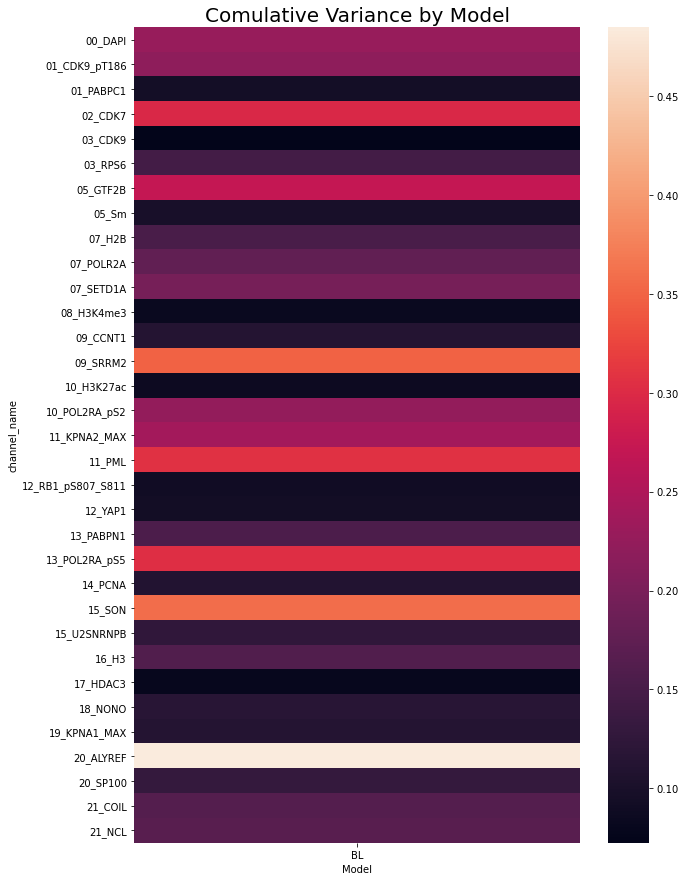

In [14]:
temp_df = stack_score_df.copy()
temp_df = temp_df.groupby(['channel_name', 'Model']).sum().reset_index()
temp_df = temp_df.pivot('channel_name', 'Model', 'channel_stddev')
#temp_df = temp_df.sort_index(level=0, ascending=True)

plt.figure(figsize=(10,15))
sns.heatmap(temp_df)
_ = plt.title('Comulative Variance by Model', fontsize=20)

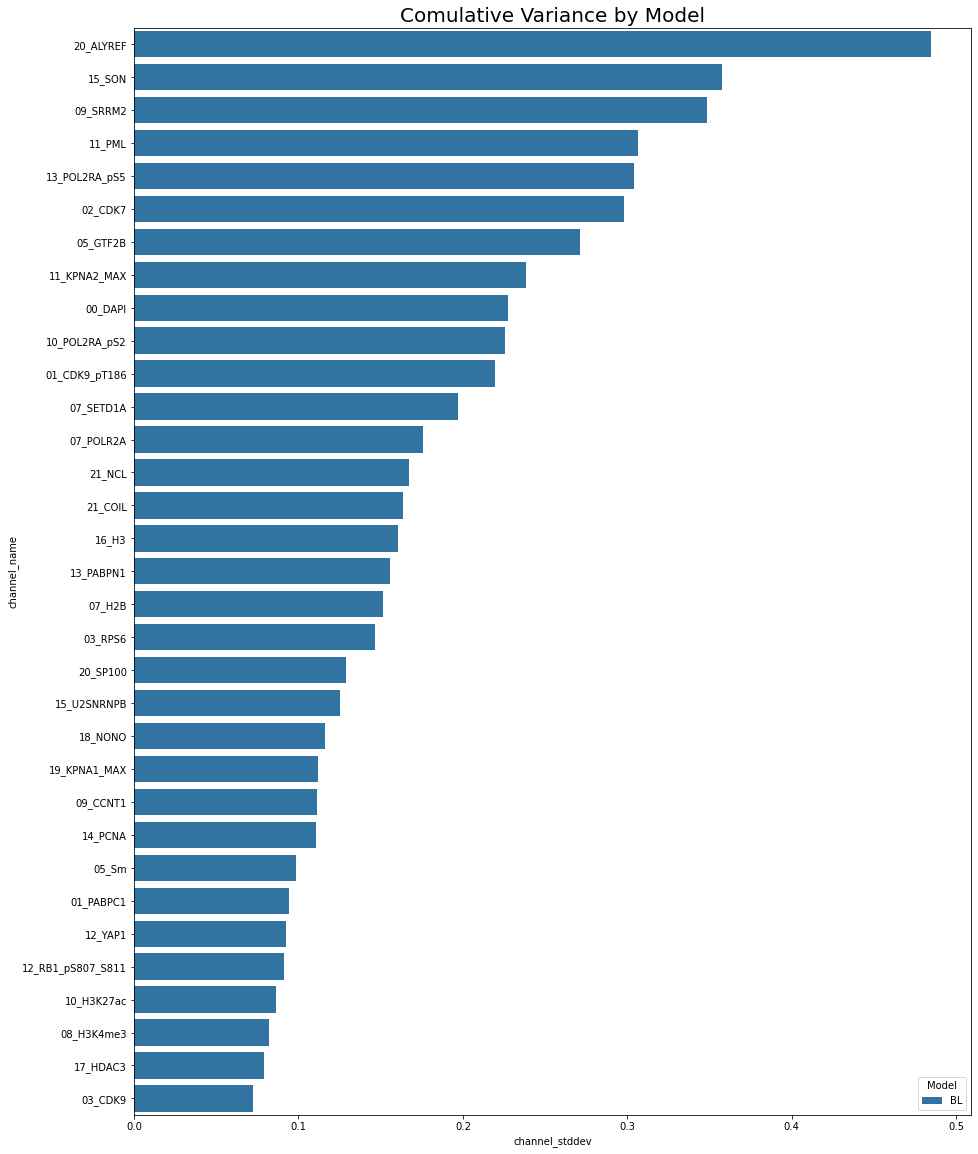

In [15]:
temp_df = stack_score_df.copy()
temp_df = temp_df.groupby(['channel_name', 'Model']).sum().reset_index()
temp_df = temp_df.sort_values(by=['channel_stddev', 'Model'], ascending=False)
    
plt.figure(figsize=(15,20))
sns.barplot(
        data=temp_df,
        x="channel_stddev",
        y="channel_name",
        hue="Model",
        #hue_order=order,
        orient="h",
        #palette="viridis"
        )
_ = plt.title('Comulative Variance by Model', fontsize=20)

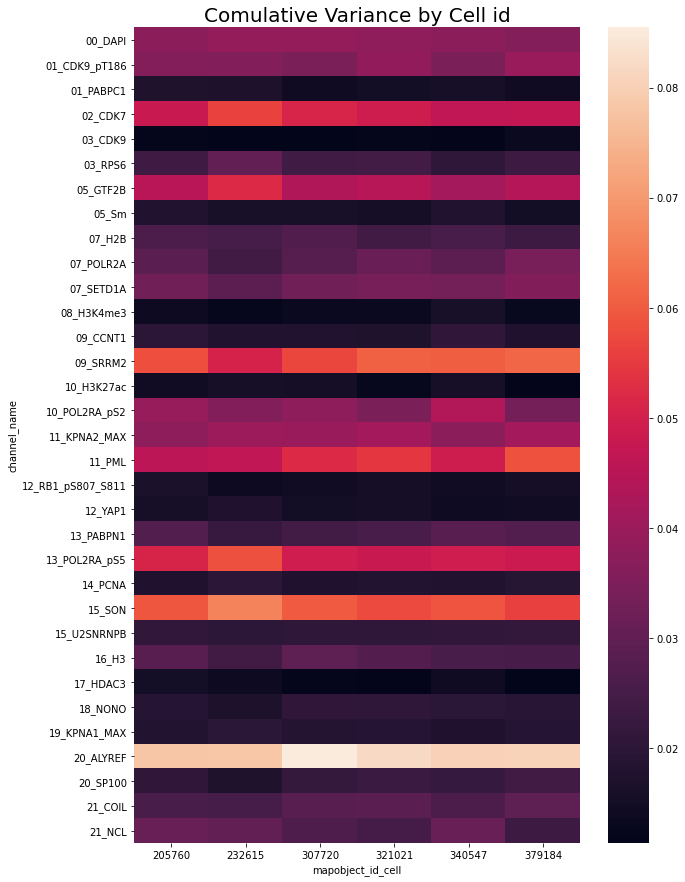

In [16]:
temp_df = stack_score_df.copy()
temp_df = temp_df.groupby(['channel_name', 'mapobject_id_cell']).sum().reset_index()
temp_df = temp_df.pivot('channel_name', 'mapobject_id_cell', 'channel_stddev')
temp_df = temp_df.sort_index(level=0, ascending=True)


plt.figure(figsize=(10,15))
sns.heatmap(temp_df)
_ = plt.title('Comulative Variance by Cell id', fontsize=20)

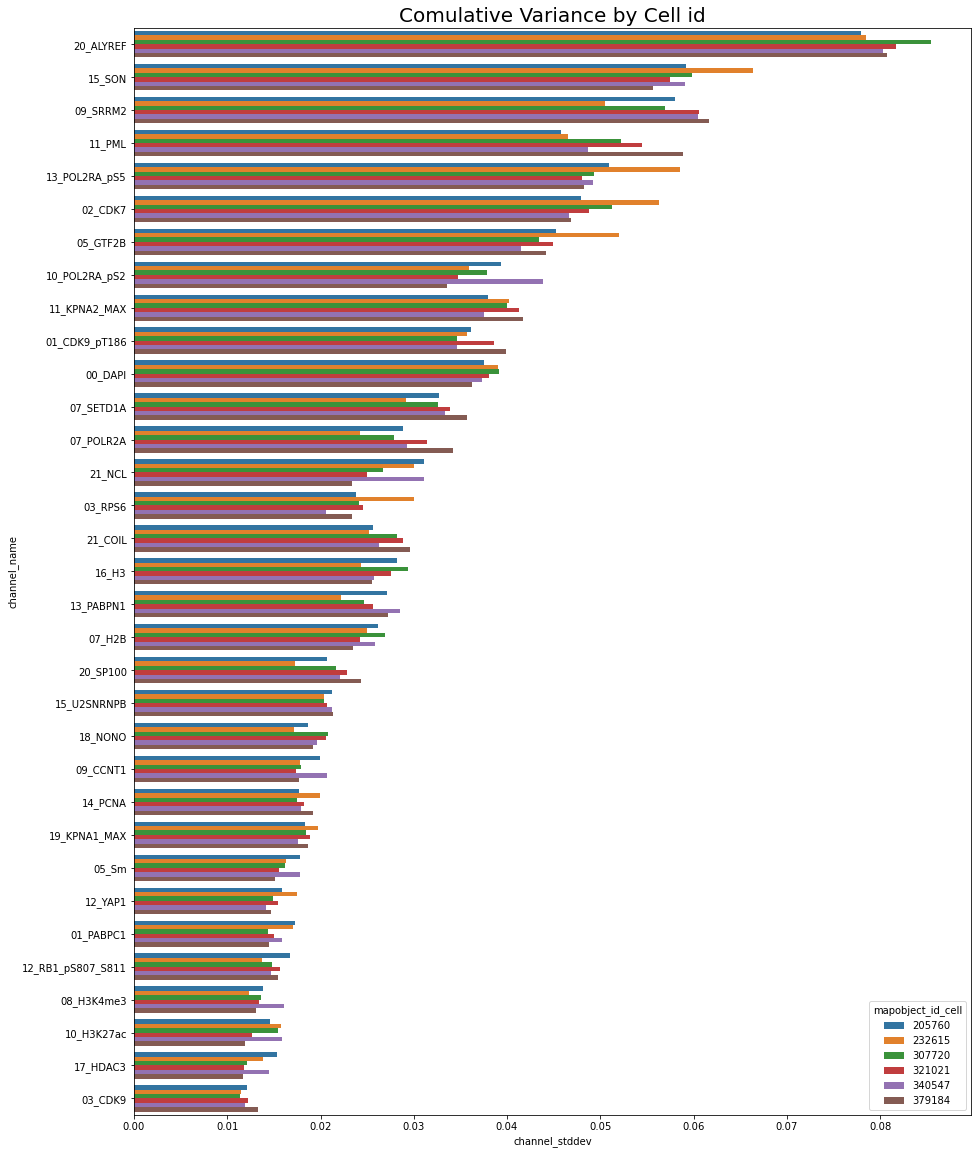

In [17]:
temp_df = stack_score_df.copy()
temp_df = temp_df.groupby(['channel_name', 'mapobject_id_cell']).sum().reset_index()
temp_df = temp_df.sort_values(by=['channel_stddev', 'mapobject_id_cell'], ascending=False)
    
plt.figure(figsize=(15,20))
sns.barplot(
        data=temp_df,
        x="channel_stddev",
        y="channel_name",
        hue="mapobject_id_cell",
        #hue_order=order,
        orient="h",
        #palette="viridis"
        )
_ = plt.title('Comulative Variance by Cell id', fontsize=20)

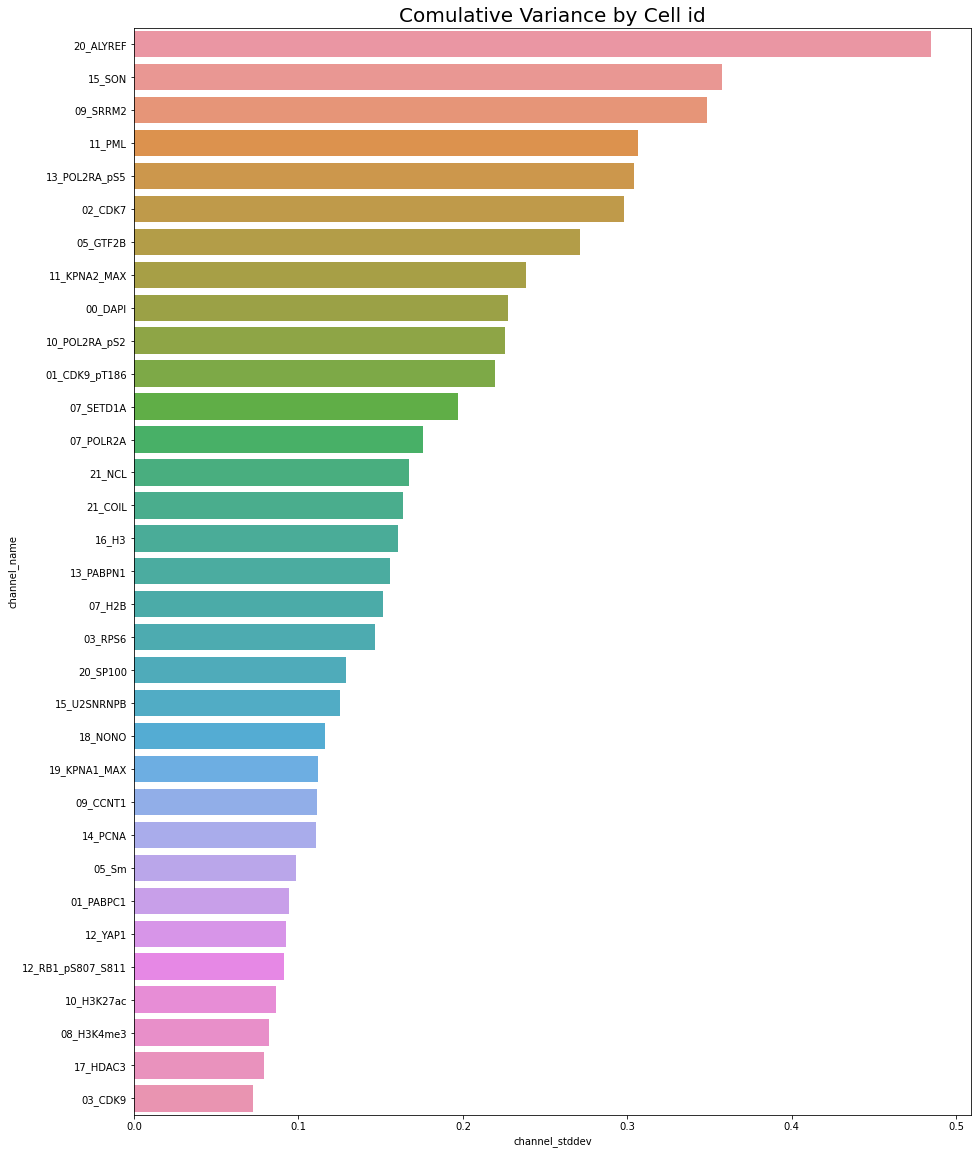

In [18]:
temp_df = stack_score_df.copy()
temp_df = temp_df.groupby(['channel_name']).sum().reset_index()
temp_df = temp_df.sort_values(by=['channel_stddev'], ascending=False)
    
plt.figure(figsize=(15,20))
sns.barplot(
        data=temp_df,
        x="channel_stddev",
        y="channel_name",
        #hue_order=order,
        orient="h",
        #palette="viridis"
        )
_ = plt.title('Comulative Variance by Cell id', fontsize=20)

In [19]:
params['models_list']

['BL']

In [20]:
top_80_df = pd.DataFrame(columns=['Raw', 'Model'])

for model_name in params['models_list']:
    mask = (stack_score_df.Model == model_name)
    temp_df = stack_score_df[mask].copy()
    temp_df = temp_df.groupby(['channel_name']).sum().reset_index()
    temp_df = temp_df.sort_values(by=['channel_stddev'], ascending=False).reset_index()
    temp_df = temp_df.drop(['index'], axis=1)
    total = np.sum(temp_df.channel_stddev)
    temp_df.channel_stddev = (temp_df.channel_stddev / total)
    temp_df['Cum_stddev'] = temp_df.channel_stddev.cumsum()
    idx = temp_df[temp_df.Cum_stddev < 0.8].tail(1).index[0]
    
    top_80_df = top_80_df.append({'Raw': idx, 'Model': model_name}, ignore_index=True)

top_80_df.sort_values(by=['Raw'])

Raw Model
0  19    BL